In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree


In [2]:
#Importando Dados do Big Query
from google.cloud import bigquery
from google.api_core import exceptions

key_path = "keyfile.json"

try:
    client = bigquery.Client.from_service_account_json(key_path)

    print(f"Autenticação bem-sucedida com o projeto: {client.project}")

except FileNotFoundError:
    print(f"ERRO: O arquivo de chave não foi encontrado no caminho especificado: {key_path}")
    print("Verifique se o caminho está correto.")
    exit()
except Exception as e:
    print(f"Ocorreu um erro inesperado durante a autenticação: {e}")
    exit()


Autenticação bem-sucedida com o projeto: viitra-redu


In [3]:

data_inicio = '2020-01-01'
data_fim = '2024-12-31'

sql_query = f"""
select
     eng.cliente
    ,eng.user_id
    ,eng.environment_id
    ,eng.course_id
    ,eng.space_id
    ,eng.subject_id
    ,eng.lecture_id
    ,eng.NivelAgregacao
    ,eng.user_name
    ,eng.environment_name
    ,eng.course_name
    ,eng.space_name
    ,eng.subject_name
    ,eng.lecture_name
    ,eng.period_start_date
    ,eng.period_end_date
    ,eng.postsAmount
    ,eng.postRepliesAmount
    ,eng.helpRequestsAmount
    ,eng.helpRequestRepliesAmount
    ,eng.performance_rate
from analytics.fn_engajamento(
  DATE('{data_inicio}'),
  DATE('{data_fim}'),
  TRUE,'redu-digital',
  242,
  NULL,
  NULL,
  NULL,
  NULL,'ENV', 'YEAR'
) as eng
"""

try:
    dataframe = client.query(sql_query).to_dataframe()
    print(dataframe.head())
except exceptions.Forbidden as e:
    print(f"ERRO DE PERMISSÃO: {e}")
    print("A autenticação funcionou, mas a conta de serviço não tem permissão para acessar os dados.")
    print("Verifique os papéis de IAM (ex: 'BigQuery User') no Google Cloud Console.")

c:\Users\Matheus Monte\Documents\Classificador\env\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


        cliente  user_id  environment_id  course_id  space_id  subject_id  \
0  redu-digital     8962             242       <NA>      <NA>        <NA>   
1  redu-digital     8962             242       <NA>      <NA>        <NA>   
2  redu-digital     8962             242       <NA>      <NA>        <NA>   
3  redu-digital     8962             242       <NA>      <NA>        <NA>   
4  redu-digital     8962             242       <NA>      <NA>        <NA>   

   lecture_id NivelAgregacao        user_name       environment_name  ...  \
0        <NA>            ENV  ADALBERTO GOMES  NECTAR | Negócios 4.0  ...   
1        <NA>            ENV  ADALBERTO GOMES  NECTAR | Negócios 4.0  ...   
2        <NA>            ENV  ADALBERTO GOMES  NECTAR | Negócios 4.0  ...   
3        <NA>            ENV  ADALBERTO GOMES  NECTAR | Negócios 4.0  ...   
4        <NA>            ENV  ADALBERTO GOMES  NECTAR | Negócios 4.0  ...   

  space_name subject_name lecture_name period_start_date period_end_date  

In [4]:
## EDA dos dados importados 

In [5]:
print(dataframe.head())
dataframe.info()

        cliente  user_id  environment_id  course_id  space_id  subject_id  \
0  redu-digital     8962             242       <NA>      <NA>        <NA>   
1  redu-digital     8962             242       <NA>      <NA>        <NA>   
2  redu-digital     8962             242       <NA>      <NA>        <NA>   
3  redu-digital     8962             242       <NA>      <NA>        <NA>   
4  redu-digital     8962             242       <NA>      <NA>        <NA>   

   lecture_id NivelAgregacao        user_name       environment_name  ...  \
0        <NA>            ENV  ADALBERTO GOMES  NECTAR | Negócios 4.0  ...   
1        <NA>            ENV  ADALBERTO GOMES  NECTAR | Negócios 4.0  ...   
2        <NA>            ENV  ADALBERTO GOMES  NECTAR | Negócios 4.0  ...   
3        <NA>            ENV  ADALBERTO GOMES  NECTAR | Negócios 4.0  ...   
4        <NA>            ENV  ADALBERTO GOMES  NECTAR | Negócios 4.0  ...   

  space_name subject_name lecture_name period_start_date period_end_date  

In [6]:
dataframe.describe()

,user_id,environment_id,course_id,space_id,subject_id,lecture_id,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,14480.0,14480.0,0.0,0.0,0.0,0.0,14480.0,14480.0,14480.0,14480.0,6290.000000
mean,10997.520028,242.0,<NA>,<NA>,<NA>,<NA>,0.295028,0.004972,0.002279,0.000414,0.079632
std,1902.116301,0.0,<NA>,<NA>,<NA>,<NA>,4.76212,0.177006,0.059306,0.020352,0.259969
min,9.0,242.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
25%,9174.75,242.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
50%,11159.5,242.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
75%,12739.25,242.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
max,16250.0,242.0,<NA>,<NA>,<NA>,<NA>,281.0,13.0,3.0,1.0,1.000000


In [7]:
valores_set = dataframe.iloc[:, 16:]

In [8]:
valores_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14480 entries, 0 to 14479
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               14480 non-null  Int64  
 1   postRepliesAmount         14480 non-null  Int64  
 2   helpRequestsAmount        14480 non-null  Int64  
 3   helpRequestRepliesAmount  14480 non-null  Int64  
 4   performance_rate          6290 non-null   float64
dtypes: Int64(4), float64(1)
memory usage: 622.3 KB


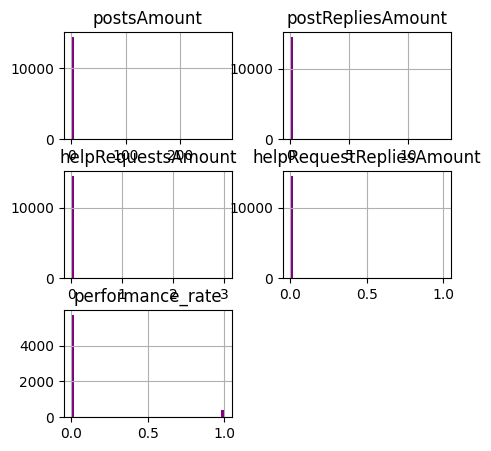

In [9]:
valores_set.hist(bins=50, figsize=(5, 5), color='purple')
plt.show()

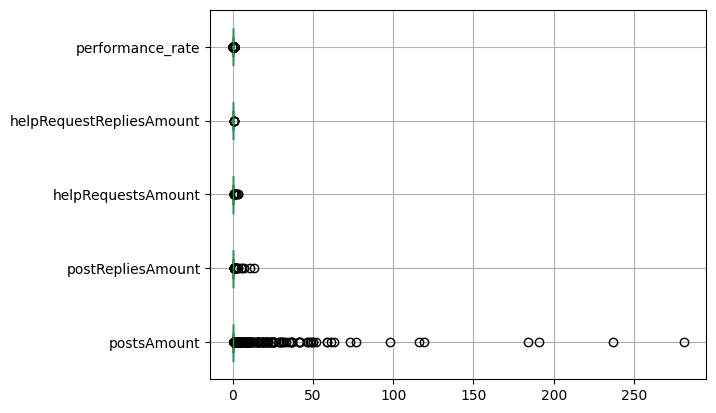

In [10]:
valores_set.boxplot(vert=False)
plt.show()

In [11]:
## pré processamento

In [12]:
train_set = valores_set.copy()

In [13]:
train_set.shape

(14480, 5)

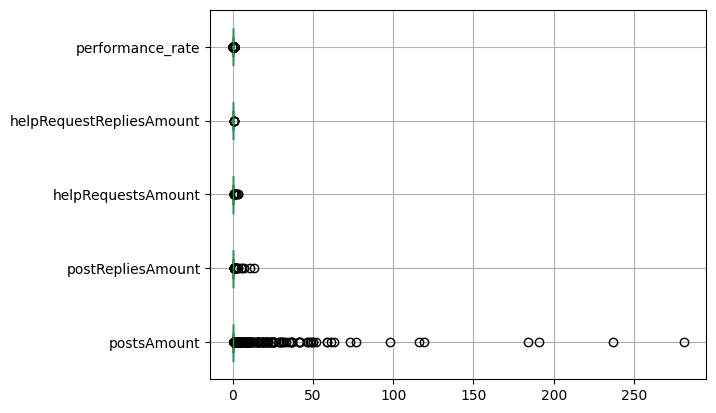

In [14]:
train_set.boxplot(vert=False)
plt.show()

In [15]:
train_set.info()
train_set.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14480 entries, 0 to 14479
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               14480 non-null  Int64  
 1   postRepliesAmount         14480 non-null  Int64  
 2   helpRequestsAmount        14480 non-null  Int64  
 3   helpRequestRepliesAmount  14480 non-null  Int64  
 4   performance_rate          6290 non-null   float64
dtypes: Int64(4), float64(1)
memory usage: 622.3 KB


,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,14480.0,14480.0,14480.0,14480.0,6290.000000
mean,0.295028,0.004972,0.002279,0.000414,0.079632
std,4.76212,0.177006,0.059306,0.020352,0.259969
min,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.000000
50%,0.0,0.0,0.0,0.0,0.000000
75%,0.0,0.0,0.0,0.0,0.000000
max,281.0,13.0,3.0,1.0,1.000000


In [16]:
train_set.head()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
0,0,0,0,0,NaN
1,0,0,0,0,NaN
2,0,0,0,0,NaN
3,0,0,0,0,NaN
4,0,0,0,0,NaN


In [17]:
inputer = KNNImputer(n_neighbors=5)
inputer.fit(train_set)

,missing_values,nan
,n_neighbors,5
,weights,'uniform'
,metric,'nan_euclidean'
,copy,True
,add_indicator,False
,keep_empty_features,False


In [18]:
train_set_inpute = inputer.transform(train_set)

In [19]:
train_set_inputado = pd.DataFrame(
    train_set_inpute,
    columns=train_set.columns,
    index=train_set.index
)

In [20]:
train_set = train_set_inputado.copy()
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14480 entries, 0 to 14479
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               14480 non-null  float64
 1   postRepliesAmount         14480 non-null  float64
 2   helpRequestsAmount        14480 non-null  float64
 3   helpRequestRepliesAmount  14480 non-null  float64
 4   performance_rate          14480 non-null  float64
dtypes: float64(5)
memory usage: 565.8 KB


In [21]:
train_set.describe()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,14480.000000,14480.000000,14480.000000,14480.000000,14480.000000
mean,0.295028,0.004972,0.002279,0.000414,0.044693
std,4.762120,0.177006,0.059306,0.020352,0.194093
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,281.000000,13.000000,3.000000,1.000000,1.000000


In [22]:
print(train_set.columns)

Index(['postsAmount', 'postRepliesAmount', 'helpRequestsAmount',
       'helpRequestRepliesAmount', 'performance_rate'],
      dtype='object')


In [23]:
scaler = MinMaxScaler()
train_set_scaled_np = scaler.fit_transform(train_set)

In [24]:
train_set_scaled = pd.DataFrame(
train_set_scaled_np,
    columns=train_set.columns,
    index=train_set.index
)

In [25]:
train_set = train_set_scaled.copy()

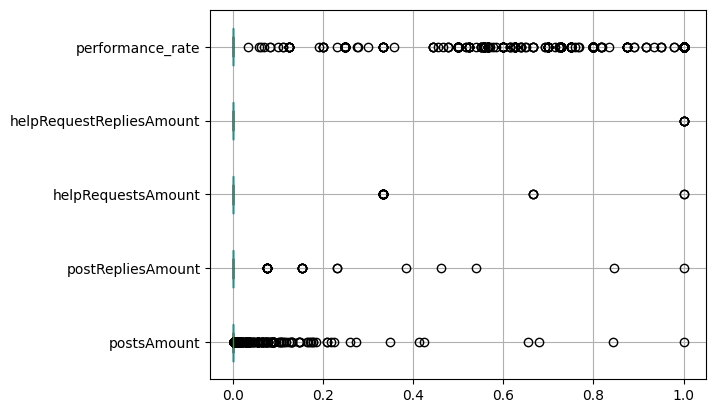

In [26]:
train_set.boxplot(vert=False)
plt.show()

In [27]:
# faixas de k para testar
k_range = range(2, 11)  # começa em 2 (não faz sentido silhouette com k=1)

# métricas
wcss = []
silhouette = []
calinski = []
davies = []
bic = []

for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(train_set)

    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(train_set, labels))
    calinski.append(calinski_harabasz_score(train_set, labels))
    davies.append(davies_bouldin_score(train_set, labels))

    # BIC com GaussianMixture
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(train_set)
    bic.append(gmm.bic(train_set))

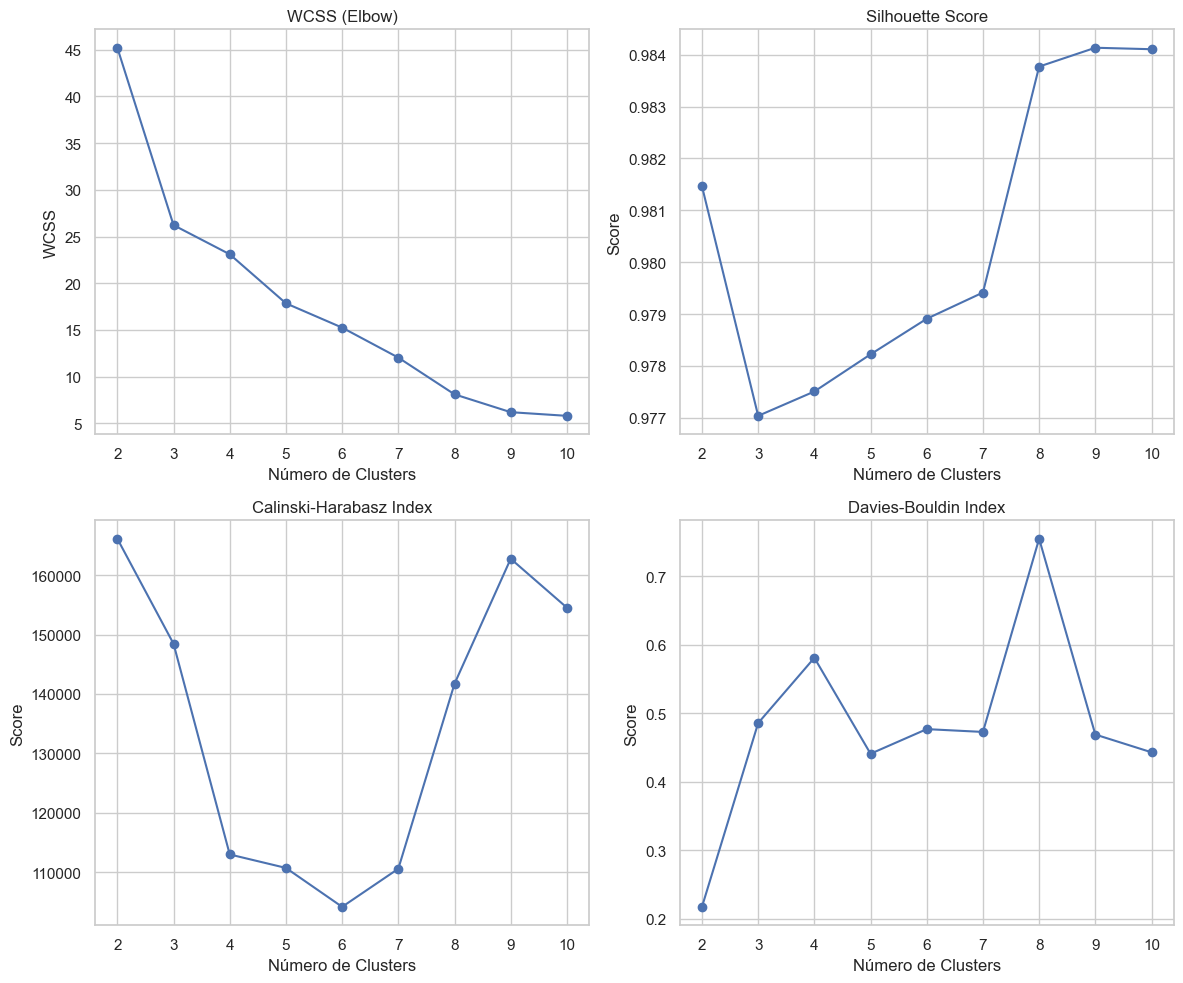

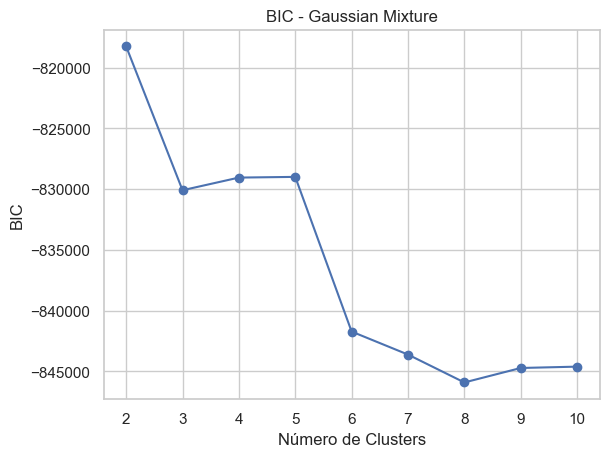

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))

# WCSS (cotovelo)
plt.subplot(2, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('WCSS (Elbow)')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

# Silhouette
plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Calinski-Harabasz
plt.subplot(2, 2, 3)
plt.plot(k_range, calinski, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Davies-Bouldin (quanto menor, melhor)
plt.subplot(2, 2, 4)
plt.plot(k_range, davies, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# BIC separado (opcional)
plt.figure()
plt.plot(k_range, bic, marker='o')
plt.title('BIC - Gaussian Mixture')
plt.xlabel('Número de Clusters')
plt.ylabel('BIC')
plt.show()


In [29]:
# Redução de dimensionalidade
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_set)

In [30]:

feature_names =  train_set.columns.tolist()
importancia = pd.DataFrame(
    data=pca.components_,
    columns=feature_names,
    index=[f'PC{i+1}' for i in range(2)]
)

print("Contribuição das variáveis em cada Componente Principal:")
print(importancia.T)

# Variância explicada por componente
print("\nVariância explicada por cada componente:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")

Contribuição das variáveis em cada Componente Principal:
                               PC1       PC2
postsAmount               0.021459  0.046672
postRepliesAmount         0.006745  0.072328
helpRequestsAmount        0.014270  0.594443
helpRequestRepliesAmount  0.009183  0.799330
performance_rate          0.999603 -0.017319

Variância explicada por cada componente:
PC1: 96.80%
PC2: 1.13%


In [31]:
# Treinamento do K-Means
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(X_pca)

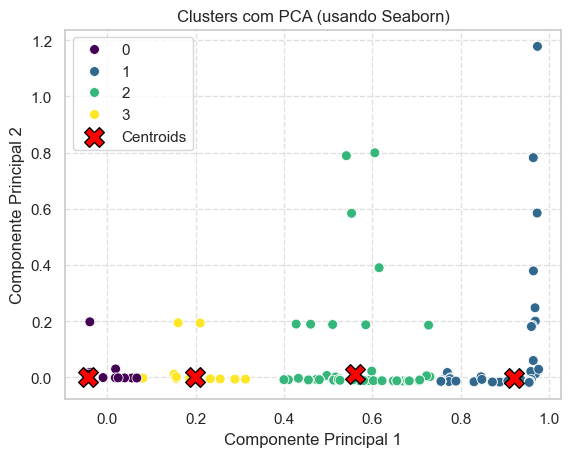

In [32]:

df_pca = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': y_kmeans
})

sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='red', label='Centroids', marker='X', edgecolors='black')

plt.title('Clusters com PCA (usando Seaborn)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [33]:
tabela_contagem = pd.Series(y_kmeans).value_counts()


# Exibe a tabela final
print("Quantidade de itens por cluster:")
print(tabela_contagem)

Quantidade de itens por cluster:
0    13690
1      531
2      198
3       61
Name: count, dtype: int64


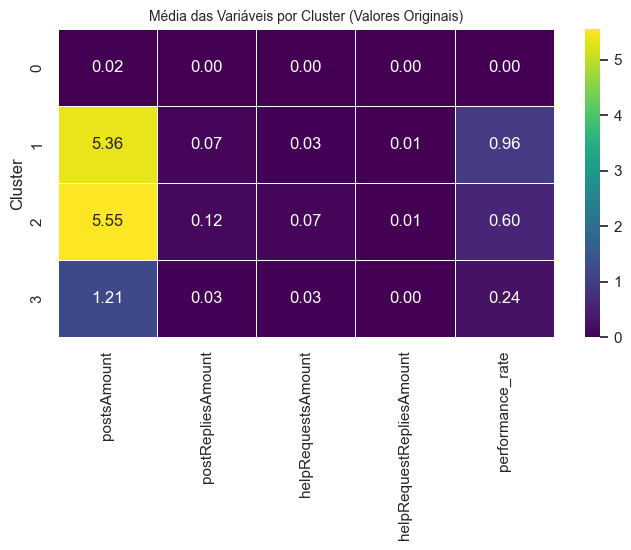

In [34]:
dados_revertidos_np = scaler.inverse_transform(train_set)
train_set_revertido = pd.DataFrame(dados_revertidos_np, columns=train_set.columns, index=train_set.index)

dados_originais_com_clusters = train_set_revertido.copy()
dados_originais_com_clusters['cluster'] = y_kmeans
cluster_means = dados_originais_com_clusters.groupby('cluster').mean()

plt.figure(figsize=(8, 4))

sns.heatmap(
    cluster_means,
    
    annot=True,
    fmt='.2f',
    cmap='viridis',
    linewidths=.5
)

plt.title('Média das Variáveis por Cluster (Valores Originais)', fontsize=10)
plt.ylabel('Cluster', fontsize=12)
plt.show()

--- Regras da Árvore de Decisão ---
|--- performance_rate <= 0.12
|   |--- class: 0
|--- performance_rate >  0.12
|   |--- performance_rate <= 0.78
|   |   |--- performance_rate <= 0.40
|   |   |   |--- class: 3
|   |   |--- performance_rate >  0.40
|   |   |   |--- class: 2
|   |--- performance_rate >  0.78
|   |   |--- class: 1


--- Visualização da Árvore ---


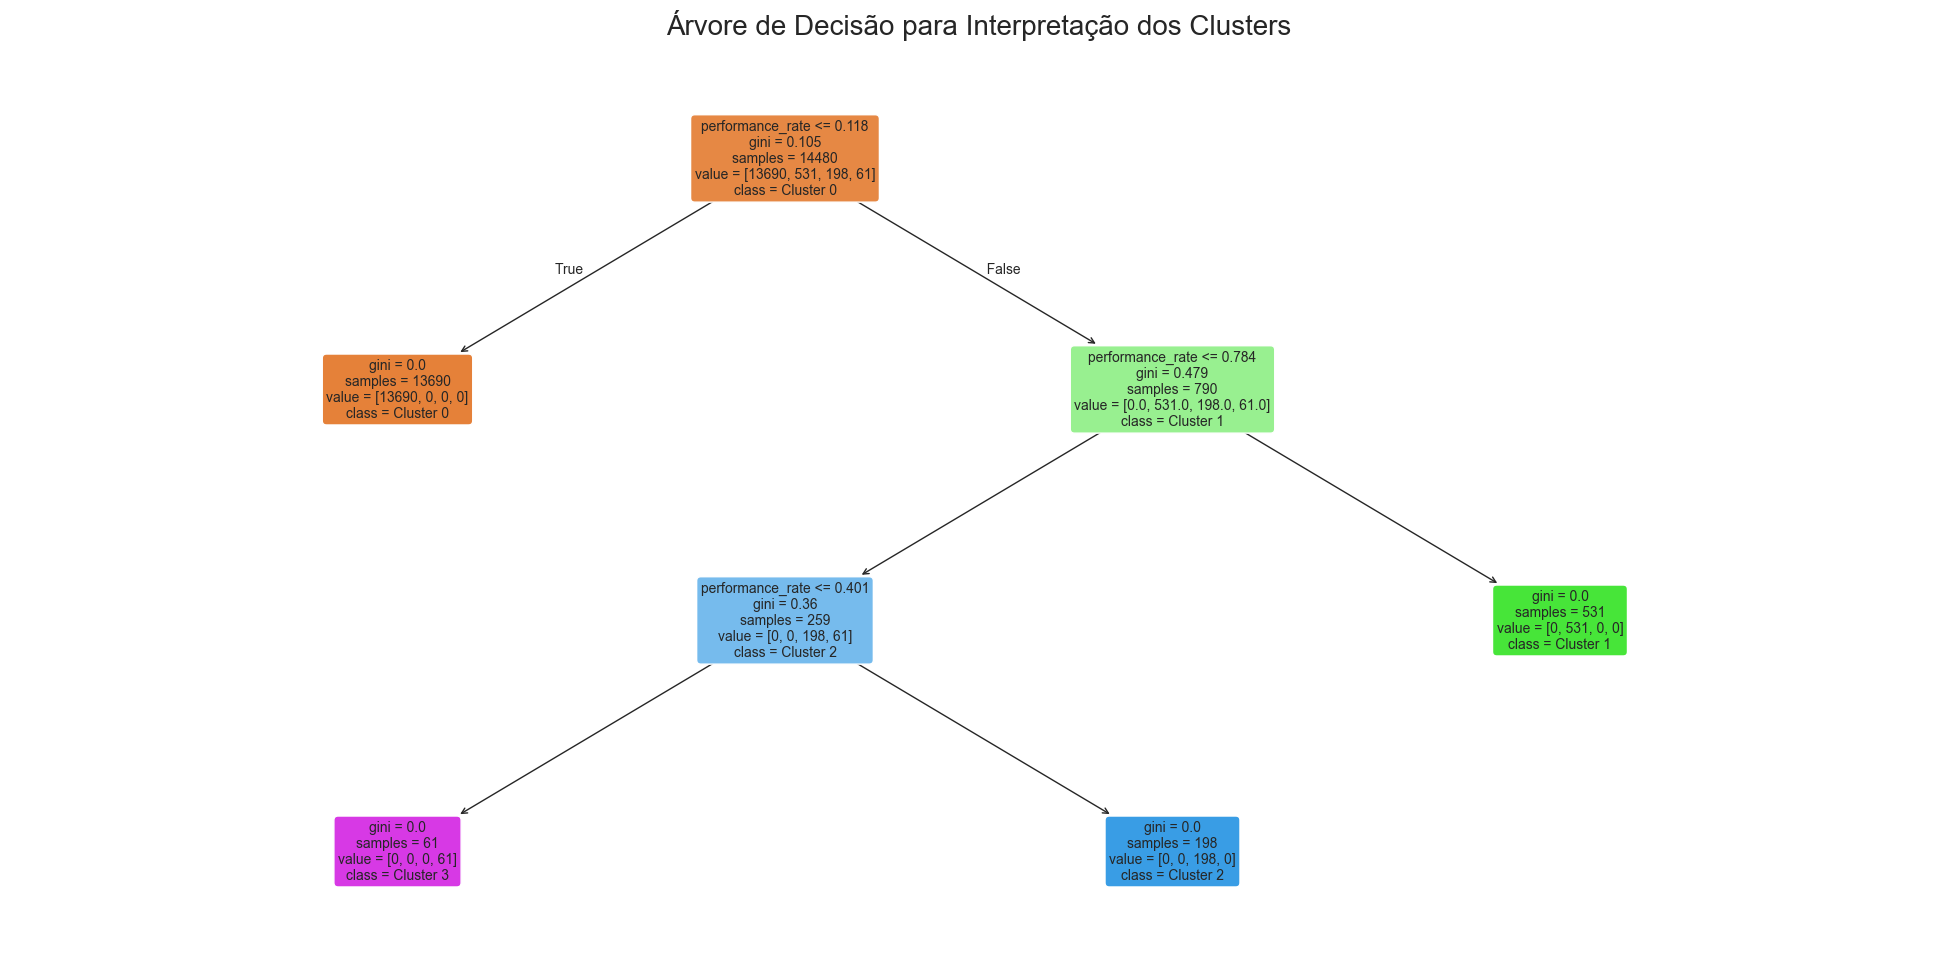

In [35]:
# --- 2. TREINAR A ÁRVORE DE DECISÃO ---

X = train_set
y = y_kmeans

arvore_de_decisao = DecisionTreeClassifier(max_depth=3, random_state=42)

arvore_de_decisao.fit(X, y)


print("--- Regras da Árvore de Decisão ---")
nomes_features = X.columns.tolist()
regras_texto = export_text(arvore_de_decisao, feature_names=nomes_features)
print(regras_texto)


print("\n--- Visualização da Árvore ---")

nomes_classes = [f'Cluster {i}' for i in sorted(np.unique(y))]

plt.figure(figsize=(25, 12))
plot_tree(
    arvore_de_decisao,
    feature_names=nomes_features,
    class_names=nomes_classes,
    filled=True, 
    rounded=True, 
    fontsize=10
)
plt.title("Árvore de Decisão para Interpretação dos Clusters", fontsize=20)
plt.show()

In [36]:

train_set['cluster'] = y_kmeans

centroids_interpretacao_df = train_set.groupby('cluster').mean()

print("--- Médias das Variáveis Originais por Cluster ---")
print(centroids_interpretacao_df)
print("-" * 50)

mapa_de_labels = {}

id_consistente = centroids_interpretacao_df['postsAmount'].idxmax()
mapa_de_labels[id_consistente] = "Engajamento consistente"

# "Não interagem": Menor performance rate
id_nao_interagem = centroids_interpretacao_df['performance_rate'].idxmin()
mapa_de_labels[id_nao_interagem] = "Desempenho Crítico"

# Identifica e classifica os dois clusters restantes
indices_restantes = [c for c in centroids_interpretacao_df.index if c not in mapa_de_labels]

if centroids_interpretacao_df.loc[indices_restantes[0], 'performance_rate'] > centroids_interpretacao_df.loc[indices_restantes[1], 'performance_rate']:
    mapa_de_labels[indices_restantes[0]] = "Engajamento excelente"
    mapa_de_labels[indices_restantes[1]] = "Alerta de Desengajamento"
else:
    mapa_de_labels[indices_restantes[1]] = "Engajamento excelente"
    mapa_de_labels[indices_restantes[0]] = "Alerta de Desengajamento"


print("\n--- Mapa de Labels Gerado Automaticamente ---")
print(mapa_de_labels)

# Passo 4: Aplicar o mapa gerado
train_set['categoria_interacao'] = train_set['cluster'].map(mapa_de_labels)

print("\n--- Contagem final das novas categorias ---")
print(train_set['categoria_interacao'].value_counts())

--- Médias das Variáveis Originais por Cluster ---
         postsAmount  postRepliesAmount  helpRequestsAmount  \
cluster                                                       
0           0.000066           0.000056            0.000024   
1           0.019060           0.005360            0.010044   
2           0.019753           0.008936            0.023569   
3           0.004317           0.002522            0.010929   

         helpRequestRepliesAmount  performance_rate  
cluster                                              
0                        0.000000          0.000052  
1                        0.007533          0.963854  
2                        0.010101          0.604960  
3                        0.000000          0.243421  
--------------------------------------------------

--- Mapa de Labels Gerado Automaticamente ---
{np.int32(2): 'Engajamento consistente', np.int32(0): 'Desempenho Crítico', 1: 'Engajamento excelente', 3: 'Alerta de Desengajamento'}

--- Contagem

In [37]:
dataset_clss = train_set.copy()
dataset_clss.head()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
0,0.0,0.0,0.0,0.0,0.0,0,Desempenho Crítico
1,0.0,0.0,0.0,0.0,0.0,0,Desempenho Crítico
2,0.0,0.0,0.0,0.0,0.0,0,Desempenho Crítico
3,0.0,0.0,0.0,0.0,0.0,0,Desempenho Crítico
4,0.0,0.0,0.0,0.0,0.0,0,Desempenho Crítico


In [38]:
dataset_clss.tail()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
14475,0.0,0.0,0.0,0.0,0.0,0,Desempenho Crítico
14476,0.0,0.0,0.0,0.0,0.0,0,Desempenho Crítico
14477,0.0,0.0,0.0,0.0,0.0,0,Desempenho Crítico
14478,0.0,0.0,0.0,0.0,0.0,0,Desempenho Crítico
14479,0.0,0.0,0.0,0.0,0.0,0,Desempenho Crítico


In [39]:
dataset_clss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14480 entries, 0 to 14479
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               14480 non-null  float64
 1   postRepliesAmount         14480 non-null  float64
 2   helpRequestsAmount        14480 non-null  float64
 3   helpRequestRepliesAmount  14480 non-null  float64
 4   performance_rate          14480 non-null  float64
 5   cluster                   14480 non-null  int32  
 6   categoria_interacao       14480 non-null  object 
dtypes: float64(5), int32(1), object(1)
memory usage: 735.4+ KB


In [40]:
dataframe['categoria_engajamento'] = dataset_clss['categoria_interacao']

In [41]:
dataframe.head()

,cliente,user_id,environment_id,course_id,space_id,subject_id,lecture_id,NivelAgregacao,user_name,environment_name,...,subject_name,lecture_name,period_start_date,period_end_date,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,categoria_engajamento
0,redu-digital,8962,242,<NA>,<NA>,<NA>,<NA>,ENV,ADALBERTO GOMES,NECTAR | Negócios 4.0,...,None,None,2020-01-01,2020-12-31,0,0,0,0,NaN,Desempenho Crítico
1,redu-digital,8962,242,<NA>,<NA>,<NA>,<NA>,ENV,ADALBERTO GOMES,NECTAR | Negócios 4.0,...,None,None,2021-01-01,2021-12-31,0,0,0,0,NaN,Desempenho Crítico
2,redu-digital,8962,242,<NA>,<NA>,<NA>,<NA>,ENV,ADALBERTO GOMES,NECTAR | Negócios 4.0,...,None,None,2022-01-01,2022-12-31,0,0,0,0,NaN,Desempenho Crítico
3,redu-digital,8962,242,<NA>,<NA>,<NA>,<NA>,ENV,ADALBERTO GOMES,NECTAR | Negócios 4.0,...,None,None,2023-01-01,2023-12-31,0,0,0,0,NaN,Desempenho Crítico
4,redu-digital,8962,242,<NA>,<NA>,<NA>,<NA>,ENV,ADALBERTO GOMES,NECTAR | Negócios 4.0,...,None,None,2024-01-01,2024-12-31,0,0,0,0,NaN,Desempenho Crítico


In [42]:
dataframe['data_classificacao'] = date.today()

In [43]:
dataframe.head()

,cliente,user_id,environment_id,course_id,space_id,subject_id,lecture_id,NivelAgregacao,user_name,environment_name,...,lecture_name,period_start_date,period_end_date,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,categoria_engajamento,data_classificacao
0,redu-digital,8962,242,<NA>,<NA>,<NA>,<NA>,ENV,ADALBERTO GOMES,NECTAR | Negócios 4.0,...,None,2020-01-01,2020-12-31,0,0,0,0,NaN,Desempenho Crítico,2025-08-22
1,redu-digital,8962,242,<NA>,<NA>,<NA>,<NA>,ENV,ADALBERTO GOMES,NECTAR | Negócios 4.0,...,None,2021-01-01,2021-12-31,0,0,0,0,NaN,Desempenho Crítico,2025-08-22
2,redu-digital,8962,242,<NA>,<NA>,<NA>,<NA>,ENV,ADALBERTO GOMES,NECTAR | Negócios 4.0,...,None,2022-01-01,2022-12-31,0,0,0,0,NaN,Desempenho Crítico,2025-08-22
3,redu-digital,8962,242,<NA>,<NA>,<NA>,<NA>,ENV,ADALBERTO GOMES,NECTAR | Negócios 4.0,...,None,2023-01-01,2023-12-31,0,0,0,0,NaN,Desempenho Crítico,2025-08-22
4,redu-digital,8962,242,<NA>,<NA>,<NA>,<NA>,ENV,ADALBERTO GOMES,NECTAR | Negócios 4.0,...,None,2024-01-01,2024-12-31,0,0,0,0,NaN,Desempenho Crítico,2025-08-22


In [44]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14480 entries, 0 to 14479
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cliente                   14480 non-null  object 
 1   user_id                   14480 non-null  Int64  
 2   environment_id            14480 non-null  Int64  
 3   course_id                 0 non-null      Int64  
 4   space_id                  0 non-null      Int64  
 5   subject_id                0 non-null      Int64  
 6   lecture_id                0 non-null      Int64  
 7   NivelAgregacao            14480 non-null  object 
 8   user_name                 14480 non-null  object 
 9   environment_name          14480 non-null  object 
 10  course_name               0 non-null      object 
 11  space_name                0 non-null      object 
 12  subject_name              0 non-null      object 
 13  lecture_name              0 non-null      object 
 14  period

In [45]:
# # Define o nome completo da tabela de destino
# table_id = "viitra-redu.analytics.cubo_engajamento"

# # Prepara o DataFrame para envio
# df_to_load = dataframe.copy()
# df_to_load = df_to_load.rename(columns={
#     'categoria_interacao': 'categoria_engajamento',
#     'period_start_date': 'data_inicio',
#     'period_end_date': 'data_fim'
# })

# # Converte as colunas de data para o tipo datetime do pandas, a forma mais robusta
# date_columns = ['data_inicio', 'data_fim', 'data_classificacao']
# for col in date_columns:
#     if col in df_to_load.columns:
#         df_to_load[col] = pd.to_datetime(df_to_load[col])

# # Garante que o DataFrame tenha apenas as colunas da tabela de destino
# schema_columns = [
#     'cliente', 'user_id', 'environment_id', 'course_id', 'space_id',
#     'subject_id', 'lecture_id', 'NivelAgregacao', 'user_name',
#     'environment_name', 'course_name', 'space_name', 'subject_name',
#     'lecture_name', 'postsAmount', 'postRepliesAmount',
#     'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate',
#     'categoria_engajamento', 'data_inicio', 'data_fim', 'data_classificacao'
# ]
# df_to_load = df_to_load[schema_columns]

# # Configura o job para adicionar os dados (append)
# job_config = bigquery.LoadJobConfig(write_disposition="WRITE_APPEND")

# print(f"Iniciando o carregamento de {len(df_to_load)} registros para a tabela {table_id}...")

# try:
#     # Envia o DataFrame para o BigQuery e aguarda a conclusão
#     load_job = client.load_table_from_dataframe(
#         df_to_load, table_id, job_config=job_config
#     )
#     load_job.result()
#     print("Carregamento concluído com sucesso!")
#     print(f"Foram carregadas {load_job.output_rows} linhas.")

# except Exception as e:
#     print(f"Ocorreu um erro durante o carregamento: {e}")
#     if 'load_job' in locals() and load_job.errors:
#         print("Detalhes do erro do BigQuery:", load_job.errors)

# # Executa uma consulta de verificação no BigQuery
# print("\nVerificação dos dados inseridos hoje no BigQuery:")
# query = f"""
#     SELECT data_classificacao, COUNT(1) as total_registros
#     FROM `{table_id}`
#     WHERE data_classificacao = CURRENT_DATE('America/Sao_Paulo')
#     GROUP BY 1
# """
# results_df = client.query(query).to_dataframe()
# print(results_df)